# Fine-tuned ALBERT Model for Constructiveness Detection in Steam Reviews
## *Sentiment-Analysis of Videogame Reviews on the Platform ”Steam” with a Focus on the Detection and Classification of <b>Constructiveness</b>*
---
### <u>NOTEBOOK **2**/5</u>: This Notebook handles the preprocessing of the annotated steam review data, by applying common preprocessing steps in accordance with the task at hand. In this case html markdown removal and excessive whitespace removal. The notebook also covers some initial basic statistics and plots on the annotated dataset.

In [ ]:
# Package Installations
!pip install beautifulsoup4
!pip install transformers

In [ ]:
# Imports
import pandas as pd
from google.colab import files
import io
from bs4 import BeautifulSoup
import re
from transformers import AutoTokenizer
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import sheets

In [ ]:
# Imports the csv file with the annotated steam reviews
print("Choose Annotations .csv to upload...")
uploaded = files.upload()
filename=[key for key in uploaded.keys()][0]
annotations_df = pd.read_csv(io.BytesIO(uploaded[filename]))
annotations_df.head()

Choose Annotations .csv to upload...


Saving annotaty_raw_annotations_export.csv to annotaty_raw_annotations_export (1).csv


,annotation_id,annotator,author_playtime_at_review,created_at,earnesty_choice,game,id,lead_time,review,updated_at,voted_up,votes_funny,votes_up
0,353,1,6,2024-09-18T01:57:00.066808Z,Not Constructive,Among Us,1,23.881,This game can suck my balls before I play it a...,2024-09-21T14:53:59.606566Z,False,0,1
1,359,2,11,2024-09-18T02:29:58.527195Z,Constructive,Among Us,2,25.277,Very fun little party game! Even better with f...,2024-09-21T14:54:06.577435Z,True,0,0
2,360,2,40,2024-09-18T02:33:09.647537Z,Not Constructive,Among Us,3,25.176,if you're lonely don't bother but if you're no...,2024-09-18T02:33:09.647576Z,True,1,2
3,361,2,80,2024-09-18T02:35:17.978593Z,Not Constructive,Among Us,4,29.510,fun and anoyying,2024-09-18T02:35:44.103066Z,True,0,0
4,362,2,51,2024-09-18T02:36:00.841509Z,Not Constructive,Among Us,5,14.862,when impostor is sus...,2024-09-18T02:36:00.841570Z,True,0,0


In [ ]:
annotations_df.shape

(1462, 13)

In [ ]:
print(annotations_df.columns)

Index(['annotation_id', 'annotator', 'author_playtime_at_review', 'created_at',
       'earnesty_choice', 'game', 'id', 'lead_time', 'review', 'updated_at',
       'voted_up', 'votes_funny', 'votes_up'],
      dtype='object')


In [ ]:
# Counts the annotations by annotator 1 and 2 (1 = Samuel Bullard, 2 = Marco Schreiner)
percentages = annotations_df["annotator"].value_counts(normalize=True) * 100
print(percentages.round(2))

annotator
2    82.9
1    17.1
Name: proportion, dtype: float64


In [ ]:
# Manual correction of NA values
# Shows the NA Reviews present in the dataset
for index, row in annotations_df[annotations_df["earnesty_choice"].isna()].iterrows():
    print(f'Review ID: {row["id"]}')
    print(f'Game: {row["game"]}')
    print(f'Review: {row["review"]}')
    print(f'Author Playtime at Review: {row["author_playtime_at_review"]}')
    print("\n")

Review ID: 544
Game: Garry's Mod
Review: So I decided to do a better review for this gem  I've player a bit over 1k hours  and heres a simple run down  I owned both a ttt and prophunt server, for nearly a year and easiest way to say this, 99% of this community is cancer, but ive met some people ill never forget, this game has so much potential its ridiculous easily worth 10 bucks, but if you cant afford it, pick it up on the hub for game trading and purchasing  g 2 a  for 3 its a wonderful game, and minus the cancer, the people are amazing Enjoy the game, and love it as i have come to
Author Playtime at Review: 1166


Review ID: 765
Game: PUBG: BATTLEGROUNDS
Review: ▒█▀▀█ ▒█▀▀▀ ▒█▀▀█ ▀█▀ ▒█▀▀▀█ ▒█▄░▒█ ▒█▄▄▀ ▒█▀▀▀ ▒█░▄▄ ▒█░ ▒█░░▒█ ▒█▒█▒█ ▒█░▒█ ▒█▄▄▄ ▒█▄▄█ ▄█▄ ▒█▄▄▄█ ▒█░░▀█  ▒█░░░ ▒█▀▀▀█ ▒█▀▀█ ▒█░▄▀ ▒█░░░ ▒█░░▒█ ▒█░░░ ▒█▀▄░ ▒█▄▄█ ▒█▄▄▄█ ▒█▄▄█ ▒█░▒█  ▒█▀▀█ ▒█░▒█ ▀█▀ ▒█▄░▒█ ░█▀▀█ ▒█░░░ ▒█▀▀█ ▒█░ ▒█▒█▒█ ▒█▄▄█ ▒█▄▄█ ▒█░▒█ ▄█▄ ▒█░░▀█ ▒█░▒█     That is all I am saying.
Author Playtime at Revie

In [ ]:
# Manual correction of NA value reviews
# Deletes row with ID 544 (Unsure about this one)
annotations_df = annotations_df.drop(annotations_df[annotations_df["id"] == 544].index)

# Marks earnesty_choice for row with id 765 with "Not Constructive"
annotations_df.loc[annotations_df["id"] == 765, "earnesty_choice"] = "Not Constructive"

# Marks earnesty_choice for row with id 798 with "Not Constructive"
annotations_df.loc[annotations_df["id"] == 798, "earnesty_choice"] = "Not Constructive"

In [ ]:
# Shows how many steam reviews were marked as constructive and not constructive
modifed_annoation_column_df = annotations_df.copy()
constructivity_rating_counts = modifed_annoation_column_df["earnesty_choice"].value_counts()
print(f'Constructivity Rating Counts: \n{constructivity_rating_counts}')

# Shows the ratio of constructive and not constructive reviews marked
constructivity_map = {"Constructive": 1, "Not Constructive": 0}
modifed_annoation_column_df["earnesty_choice"] = modifed_annoation_column_df["earnesty_choice"].map(constructivity_map).astype(int)
constructivity_rating_ratio = modifed_annoation_column_df["earnesty_choice"].value_counts(normalize=True) * 100
print(f'\nConstructivity Rating Ratio: \n{constructivity_rating_ratio.round(2)}')

# Shows how likely a review with the column "voted_up" as 1 (review was upvoted) or 0 (review was downvoted) was marked as either constructive or not constructive
voted_up_counts = modifed_annoation_column_df.groupby(["voted_up", "earnesty_choice"]).size()
print(f'\nVoted Up Counts: \n{voted_up_counts}')

# Shows the ratio of constructive and not constructive reviews marked based on the column "voted_up"
voted_up_ratio = modifed_annoation_column_df.groupby(["voted_up"]).size()
print(f'\nVoted Up Ratio: \n{voted_up_ratio}')

# Cross-tab to show the relationship between "voted_up" and "earnesty_choice" (constructive or not)
constructivity_vs_upvote = pd.crosstab(modifed_annoation_column_df["voted_up"], modifed_annoation_column_df["earnesty_choice"])
print(f'\nConstructivity vs. Upvote Cross-tabulation: \n{constructivity_vs_upvote}')

# Chi-Square test to determine the statistical significance of the relationship between these variables
chi2, p, dof, expected = chi2_contingency(constructivity_vs_upvote)
print(f'\nChi-Square Test:\nChi2: {chi2}\np-value: {p}\nDegrees of Freedom: {dof}\nExpected Frequencies: \n{expected}')

# If p-value is below 0.05, there is a significant relationship between upvotes and whether a review is constructive.

# Checking if there is a correlation between "voted_up" and "earnesty_choice"
correlation = modifed_annoation_column_df[["voted_up", "earnesty_choice"]].corr().iloc[0, 1]
print(f'\nCorrelation between voted_up and earnesty_choice: {correlation}')

# Grouped ratio for more granular view
grouped_ratio = modifed_annoation_column_df.groupby(["voted_up", "earnesty_choice"]).size().unstack().apply(lambda x: (x / x.sum()) * 100)
print(f'\nPercentage of Constructive/Not Constructive by Upvote Status: \n{grouped_ratio.round(2)}')

# Summary Statistics
summary_stats = modifed_annoation_column_df.describe()
print(f'\nSummary Statistics: \n{summary_stats}')

Constructivity Rating Counts: 
earnesty_choice
Not Constructive    921
Constructive        540
Name: count, dtype: int64

Constructivity Rating Ratio: 
earnesty_choice
0    63.04
1    36.96
Name: proportion, dtype: float64

Voted Up Counts: 
voted_up  earnesty_choice
False     0                  128
          1                  127
True      0                  793
          1                  413
dtype: int64

Voted Up Ratio: 
voted_up
False     255
True     1206
dtype: int64

Constructivity vs. Upvote Cross-tabulation: 
earnesty_choice    0    1
voted_up                 
False            128  127
True             793  413

Chi-Square Test:
Chi2: 21.205835171602835
p-value: 4.125067146834678e-06
Degrees of Freedom: 1
Expected Frequencies: 
[[160.74948665  94.25051335]
 [760.25051335 445.74948665]]

Correlation between voted_up and earnesty_choice: -0.12234445020198412

Percentage of Constructive/Not Constructive by Upvote Status: 
earnesty_choice     0      1
voted_up                  

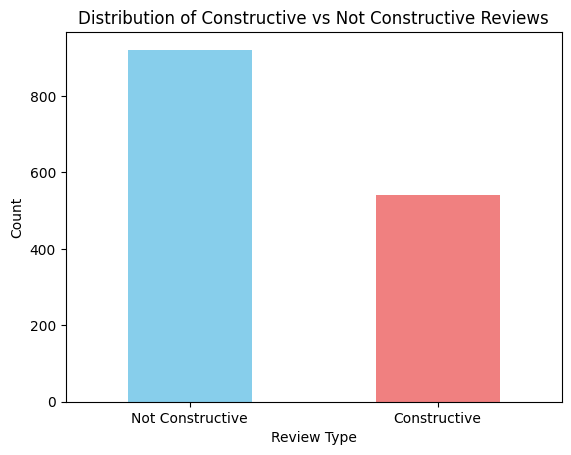

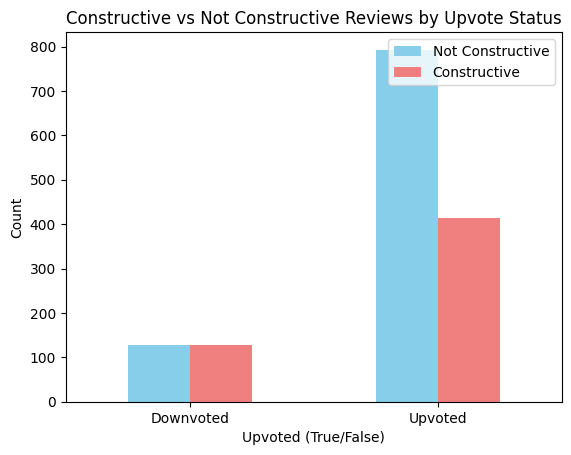

In [ ]:
# Plotting
# Constructive vs. not constructive
constructivity_rating_counts.plot(kind="bar", color=["skyblue", "lightcoral"])
plt.title("Distribution of Constructive vs Not Constructive Reviews")
plt.xlabel("Review Type")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Not Constructive", "Constructive"], rotation=0)
plt.show()

# Upvoted vs downvoted reviews and their constructivity
voted_up_counts.unstack().plot(kind="bar", stacked=False, color=["skyblue", "lightcoral"])
plt.title("Constructive vs Not Constructive Reviews by Upvote Status")
plt.xlabel("Upvoted (True/False)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Downvoted", "Upvoted"], rotation=0)
plt.legend(["Not Constructive", "Constructive"], loc="upper right")
plt.show()

In [ ]:
modifed_annoation_column_df.head()

,annotation_id,annotator,author_playtime_at_review,created_at,earnesty_choice,game,id,lead_time,review,updated_at,voted_up,votes_funny,votes_up
0,353,1,6,2024-09-18T01:57:00.066808Z,0,Among Us,1,23.881,This game can suck my balls before I play it a...,2024-09-21T14:53:59.606566Z,False,0,1
1,359,2,11,2024-09-18T02:29:58.527195Z,1,Among Us,2,25.277,Very fun little party game! Even better with f...,2024-09-21T14:54:06.577435Z,True,0,0
2,360,2,40,2024-09-18T02:33:09.647537Z,0,Among Us,3,25.176,if you're lonely don't bother but if you're no...,2024-09-18T02:33:09.647576Z,True,1,2
3,361,2,80,2024-09-18T02:35:17.978593Z,0,Among Us,4,29.510,fun and anoyying,2024-09-18T02:35:44.103066Z,True,0,0
4,362,2,51,2024-09-18T02:36:00.841509Z,0,Among Us,5,14.862,when impostor is sus...,2024-09-18T02:36:00.841570Z,True,0,0


In [ ]:
# Lead Time = Time taken to annotate a review
total_lead_time_seconds = modifed_annoation_column_df["lead_time"].sum()
total_lead_time_minutes = total_lead_time_seconds / 60
total_lead_time_hours = total_lead_time_minutes / 60
total_lead_time = round(total_lead_time_hours, 2)
print(f'Total Lead Time: {total_lead_time} hours')

Total Lead Time: 4.69 hours


In [ ]:
mean_lead_time_seconds = modifed_annoation_column_df["lead_time"].mean()
print(f'Mean Lead Time: {mean_lead_time_seconds} seconds')
print(f'Median Lead Time: {modifed_annoation_column_df["lead_time"].median()} seconds')
print(f'Mode Lead Time: {modifed_annoation_column_df["lead_time"].mode()[0]} seconds')

Mean Lead Time: 11.559598220396989 seconds
Median Lead Time: 3.499 seconds
Mode Lead Time: 2.601 seconds


In [ ]:
modified_annotations_df = modifed_annoation_column_df.copy()
modified_annotations_df.drop(columns=["annotator", "created_at", "lead_time", "updated_at", "annotation_id"], inplace=True)
modified_annotations_df.columns
modified_annotations_df.head()

,author_playtime_at_review,earnesty_choice,game,id,review,voted_up,votes_funny,votes_up
0,6,0,Among Us,1,This game can suck my balls before I play it a...,False,0,1
1,11,1,Among Us,2,Very fun little party game! Even better with f...,True,0,0
2,40,0,Among Us,3,if you're lonely don't bother but if you're no...,True,1,2
3,80,0,Among Us,4,fun and anoyying,True,0,0
4,51,0,Among Us,5,when impostor is sus...,True,0,0


In [ ]:
# Reorders the dataframe in a more sensible way (imo)
reordered_annotations_df = modified_annotations_df[["id", "game", "review", "author_playtime_at_review", "voted_up", "votes_up", "votes_funny", "earnesty_choice"]]
reordered_annotations_df.head()

,id,game,review,author_playtime_at_review,voted_up,votes_up,votes_funny,earnesty_choice
0,1,Among Us,This game can suck my balls before I play it a...,6,False,1,0,0
1,2,Among Us,Very fun little party game! Even better with f...,11,True,0,0,1
2,3,Among Us,if you're lonely don't bother but if you're no...,40,True,2,1,0
3,4,Among Us,fun and anoyying,80,True,0,0,0
4,5,Among Us,when impostor is sus...,51,True,0,0,0


In [ ]:
# ONLY ONE FALSE-POSITIVE HTML-INSTANCE FOUND SO NOT USED

cleansed_html_annotations_df = reordered_annotations_df.copy()
#html_find_counter = 0

#for index, review in cleansed_html_annotations_df["review"].items():
#    if bool(BeautifulSoup(review, "html.parser").find()):
#        soup = BeautifulSoup(review, "html.parser")
#        cleansed_review = soup.get_text()
#        html_find_counter += 1
#
#        print(f'Original review (with HTML): {review}')
#        print(f'Cleansed review: {cleansed_review}\n')
#
#        cleansed_html_annotations_df.at[index, "review"] = cleansed_review
#
#cleansed_html_annotations_df.head()
#print(f'Number of reviews with HTML in them: {html_find_counter}')

In [ ]:
# Removes excessive whitespace (To filter out potentially more meaningless data in favor of more meaningful data (BERT 512 Token Limit))
cleansed_whitespace_annotations_df = cleansed_html_annotations_df.copy()
cleansed_whitespace_annotations_df["review"] = cleansed_whitespace_annotations_df["review"].str.replace(r"\s+", " ", regex=True).str.strip()

In [ ]:
# Replaces all URLs in the reviews URls with [URL] (To remove potentially noisy data)
cleansed_url_annotations_df = cleansed_whitespace_annotations_df.copy()
cleansed_url_annotations_df["review"] = cleansed_url_annotations_df["review"].str.replace(r"(http|https|www)\S+", "[URL]", regex=True)

In [ ]:
# Approximating the tokens in each review
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def count_tokens(text):
    return len(tokenizer.tokenize(text))

cleansed_url_annotations_df["token_count"] = cleansed_url_annotations_df["review"].apply(count_tokens)

max_tokens = cleansed_url_annotations_df["token_count"].max()
mean_tokens = cleansed_url_annotations_df["token_count"].mean()
median_tokens = cleansed_url_annotations_df["token_count"].median()

print(f'Maximum tokens in a review: {max_tokens}')
print(f'Mean tokens per review: {mean_tokens}')
print(f'Median tokens per review: {median_tokens}')

max_token_review = cleansed_url_annotations_df.loc[cleansed_url_annotations_df["token_count"].idxmax()]
print("\nReview with the maximum tokens:\n", max_token_review["review"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (775 > 512). Running this sequence through the model will result in indexing errors


Maximum tokens in a review: 1755
Mean tokens per review: 41.14305270362765
Median tokens per review: 13.0

Review with the maximum tokens:
 False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans False Bans Fa

In [ ]:
# Shows the dataframe in an interactive google sheet (kinda cool colab feature)
sheet = sheets.InteractiveSheet(df=cleansed_url_annotations_df)

https://docs.google.com/spreadsheets/d/17Kfa6k6JFgr6RmILH9GxhOX8Sw6q7ZCfvHv6ZYo5fxk#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [ ]:
cleansed_url_annotations_df.to_csv("preprocessed_annotations.csv", index=False)
files.download("preprocessed_annotations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>